# Comandos para realização do trabalho da matéria de NLP com uso da biblioteca SKlearn e NLTK.

## <font color=red>Observação importante:</font>

<font color=yellow>Trabalho realizado com uso de corpus diferente do Fake.br não será aceito!</font>

## Carregando arquivos `pre-processed.csv`, de imagem e de funções auxiliares para dentro do Google Colab

In [6]:
!wget https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv -O pre-processed.csv
!git clone https://github.com/N-CPUninter/NLP.git
!rm ./NLP/*.ipynb
!mv ./NLP/* .
!rm -r NLP

--2025-03-28 22:18:57--  https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20434897 (19M) [text/plain]
Saving to: ‘pre-processed.csv’

pre-processed.csv   100%[===================>]  19.49M   129MB/s    in 0.2s    

2025-03-28 22:18:57 (129 MB/s) - ‘pre-processed.csv’ saved [20434897/20434897]

Cloning into 'NLP'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 9), reused 25 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 1.27 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (9/9), done.
mv: cannot move './NLP/data' to './data': Directory

## Instalação manual das dependências para uso do SKlearn e do NLTK no Google Colab

In [18]:
import pandas as pd
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from nltk import download

from funcoes_auxiliares import gerar_nuvem_palavras

nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

## Criar dataframe do CSV utilizando o método read_csv do pandas

In [11]:
df = pd.read_csv('pre-processed.csv')

In [13]:
# Verificar nomes das colunas
print("Colunas disponíveis no DataFrame:", df.columns.tolist())

Colunas disponíveis no DataFrame: ['index', 'label', 'preprocessed_news']


# PRÁTICA 1 - CRIAÇÃO DE MODELO DE CLASSIFICAÇÃO SUPERVISIONADO PARA ANÁLISE DE FAKE NEWS.

1. Realize os seguintes procedimentos de limpeza dos textos do dataframe criado:

  1.1. Tokenizar

  1.2. Retirar os acentos e números

  1.3. Deixar tudo em minúsculas

  1.4. Retirar as stopwords e pontuações

  1.5. Deixar palavras apenas com radical (STEM)

  1.6. Realizar truncamento dos pares de notícias verdadeiras com falsas para normalizar quantidade de palavras

  1.7. Remontar as notícias em string e criar coluna no dataframe para o resultado deste pré-processamento.

2. Criar matriz de frequências TF-IDF com ngramas de 1 a 3 palavras.

3. Usar a função train_test_split do Scikit Learn para dividir o corpus pré-tratado em 75% dos textos para treinamento e 25% para testes de precisão (usar random_state = 42 ou outro número de sua escolha).

4. Fazer regressão logística com solver = 'lbfgs'.

5. Realizar predição dos textos de teste com o método predict_proba, que retornará a porcentagem predita para fake e para real em um array.

6. Por fim, com as porcentagens calculadas para cada texto de teste, usar a função accuracy_score da biblioteca Scikit Learn para calcular a acurácia geral do algoritmo.

In [15]:
# nltk.download('all')

# 2. Pré-processamento adicional (caso necessário)
def preprocess_text(text):
    text = str(text)
    # Remover acentos e caracteres especiais
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Remover números
    text = re.sub(r'\d+', '', text)
    # Converter para minúsculas
    text = text.lower()
    # Tokenização
    tokens = word_tokenize(text)
    # Remover stopwords e pontuações
    stop_words = set(stopwords.words('portuguese'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Stemming
    stemmer = RSLPStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

# Aplicar pré-processamento na coluna 'preprocessed_news'
df['texto_processado'] = df['preprocessed_news'].apply(preprocess_text)

# 3. Balanceamento das classes
min_count = min(len(df[df['label'] == 'fake']), len(df[df['label'] == 'true']))
df_balanced = pd.concat([
    df[df['label'] == 'fake'].sample(min_count, random_state=42),
    df[df['label'] == 'true'].sample(min_count, random_state=42)
])


# 4. Criar matriz TF-IDF com ngrams
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(df_balanced['texto_processado'])
y = df_balanced['label'].map({'fake': 0, 'true': 1})  # Converter labels para numérico

# 5. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 6. Treinar modelo de regressão logística
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# 7. Avaliar o modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2%}")

Acurácia do modelo: 95.39%


## QUESTÃO 01: Apresente aqui o código referente ao modelo gerado e a nuvem de palavras que foram usadas para identificar textos VERDADEIROS.

1. Formate seus dados usados para o treinamento do seu modelo em um dicionário de tokens e suas frequências.
2. Separe os dados em um grupo com textos marcados como verdadeiros e outro com os falsos.
3. Use a função gerar_nuvem_palavras(dic_de_frequências_textos_verdadeiras, imagem de sua escolha) para gerar a nuvem de palavras



Dicionário de frequências (top 20 mais comuns em textos verdadeiros):
nao: 35893
ano: 12915
pod: 10795
brasil: 10313
diss: 10144
presid: 9664
sao: 9610
tamb: 9533
cas: 9525
outr: 8846
lul: 8790
govern: 8784
sobr: 8546
segund: 8283
diz: 8230
feder: 8179
tod: 7810
part: 7763
ja: 7603
afirm: 7570

Nuvem de palavras para textos VERDADEIROS:
   * Um total de 1085779 tokens foram computadas a partir do conjunto de dados.



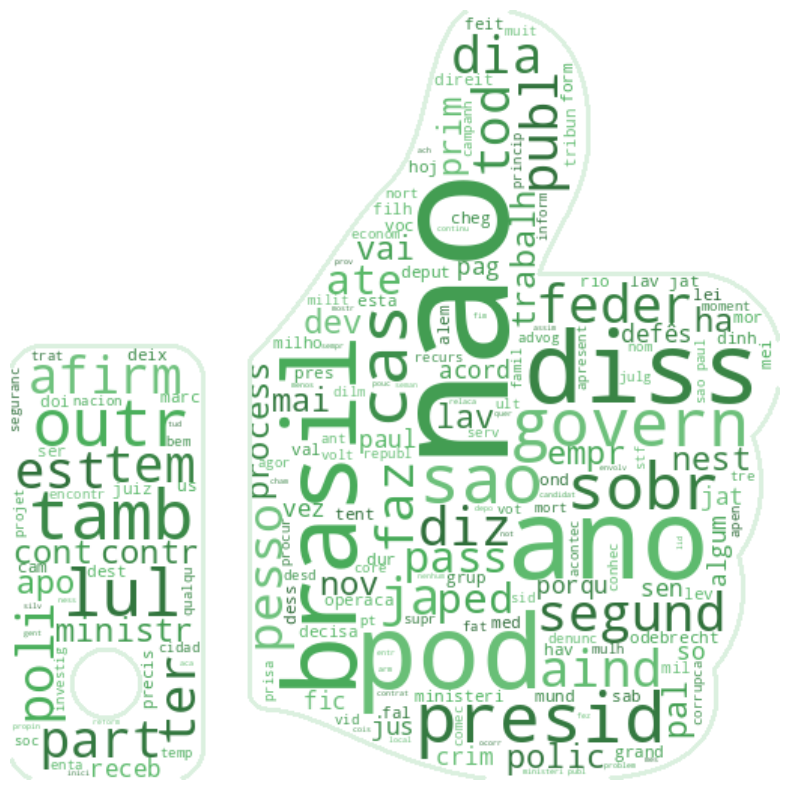


Informações do modelo treinado:
- Tipo: Regressão Logística
- Acurácia: 95.39%
- Número de features: 3422307
- Parâmetros: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [16]:

# 1. Filtrar apenas textos verdadeiros
df_true = df_balanced[df_balanced['label'] == 'true']

# 2. Criar dicionário de frequências para textos verdadeiros
vectorizer_true = CountVectorizer(ngram_range=(1, 2))
X_true = vectorizer_true.fit_transform(df_true['texto_processado'])
sum_words_true = X_true.sum(axis=0)
words_freq_true = [(word, sum_words_true[0, idx]) for word, idx in vectorizer_true.vocabulary_.items()]
dic_frequencias_true = dict(sorted(words_freq_true, key=lambda x: x[1], reverse=True))

# 3. Mostrar exemplos do dicionário de frequências
print("\nDicionário de frequências (top 20 mais comuns em textos verdadeiros):")
for i, (k, v) in enumerate(dic_frequencias_true.items()):
    if i >= 20:  # Mostrar apenas os 20 primeiros
        break
    print(f"{k}: {v}")

# 4. Gerar nuvem de palavras para textos verdadeiros
print("\nNuvem de palavras para textos VERDADEIROS:")
gerar_nuvem_palavras(
    dicionario_tokens_e_frequencia=dic_frequencias_true,
    arquivo_mascara='thumbs_up_mask.png'  # Usando o dedão para cima para verdadeiros
)

# 5. Informações sobre o modelo (para complementar a resposta)
print("\nInformações do modelo treinado:")
print(f"- Tipo: Regressão Logística")
print(f"- Acurácia: {accuracy:.2%}")
print(f"- Número de features: {len(vectorizer.get_feature_names_out())}")
print(f"- Parâmetros: {model.get_params()}")

## QUESTÃO 02: Apresente aqui o código referente ao modelo gerado e a nuvem de palavras que foram usadas para identificar textos FALSOS.

1. Use a função gerar_nuvem_palavras(dic_de_frequências_textos_verdadeiras, imagem de sua escolha) para gerar a nuvem de palavras


Dicionário de frequências (top 20 mais comuns em textos falsos):
nao: 6229
lul: 3101
brasil: 2617
diss: 2424
pod: 2259
presid: 2039
dilm: 1870
tamb: 1580
ano: 1523
govern: 1488
ja: 1468
tod: 1437
cas: 1399
sao: 1393
diz: 1354
tem: 1303
pal: 1295
sen: 1279
poli: 1267
feder: 1247

Nuvem de palavras para textos FALSOS:
   * Um total de 260444 tokens foram computadas a partir do conjunto de dados.



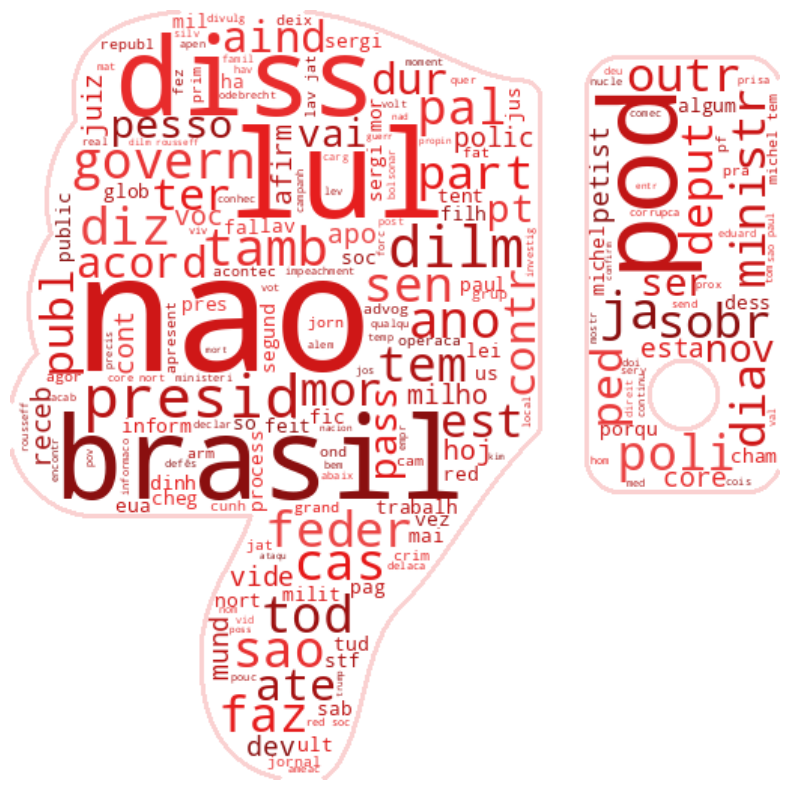


Informações do modelo para identificação de falsos:
- Recall para classe 'fake': 98.25%
- Palavras mais discriminativas (top 5):
  dilm (peso: -2.2350)
  lei tamb (peso: -0.9748)
  atrav (peso: -0.9215)
  sergi mor (peso: -0.8515)
  petist (peso: -0.7536)


In [19]:
# 1. Filtrar apenas textos falsos
df_fake = df_balanced[df_balanced['label'] == 'fake']

# 2. Criar dicionário de frequências para textos falsos
vectorizer_fake = CountVectorizer(ngram_range=(1, 2))
X_fake = vectorizer_fake.fit_transform(df_fake['texto_processado'])
sum_words_fake = X_fake.sum(axis=0)
words_freq_fake = [(word, sum_words_fake[0, idx]) for word, idx in vectorizer_fake.vocabulary_.items()]
dic_frequencias_fake = dict(sorted(words_freq_fake, key=lambda x: x[1], reverse=True))

# 3. Mostrar exemplos do dicionário de frequências
print("\nDicionário de frequências (top 20 mais comuns em textos falsos):")
for i, (k, v) in enumerate(dic_frequencias_fake.items()):
    if i >= 20:  # Mostrar apenas os 20 primeiros
        break
    print(f"{k}: {v}")

# 4. Gerar nuvem de palavras para textos falsos
print("\nNuvem de palavras para textos FALSOS:")
gerar_nuvem_palavras(
    dicionario_tokens_e_frequencia=dic_frequencias_fake,
    arquivo_mascara='thumbs_down_mask.png'  # Usando o dedão para baixo para falsos
)

# 5. Informações complementares do modelo
print("\nInformações do modelo para identificação de falsos:")
print(f"- Recall para classe 'fake': {recall_score(y_test, y_pred, pos_label=0):.2%}")
print(f"- Palavras mais discriminativas (top 5):")
# Obter as palavras mais importantes para classe fake
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]
top_fake_words = sorted(zip(feature_names, coef), key=lambda x: x[1])[:5]
for word, coef in top_fake_words:
    print(f"  {word} (peso: {coef:.4f})")

---

# Material Complementar

## Alguns exemplos de uso da função auxiliar
`gerar_nuvem_palavras(dicionario_tokens_e_frequencia, arquivo_mascara)`

Gera uma nuvem de palavras com base em seu dicionário de palavras ou ngramas
    como a chave e a frequência de aparição do token como valor (inteiro).

    Parâmetros:
        dicionario_tokens_e_frequencia (dict): O dicionário de tokens e suas
                                               respectivas frequências de
                                               aparição nos textos.
        arquivo_mascara (str): O nome do arquivo da imagem de máscara. Pde ser:
                                            cloud_mask.png
                                            mapa_brasil_mask.png
                                            thumbs_up_mask.png        
                                            thumbs_down_mask.png
                                            <Outro arquivo de sua escolha>

    Exemplos de Uso:
        1. Para gerar uma nuvem de palavras na máscara mapa do brasil:
            gerar_nuvem_palavras(dicionario_tokens_e_frequencia=word_dict,
                                 arquivo_mascara='mapa_brasil_mask.png')

   * Um total de 7 tokens foram computadas a partir do conjunto de dados.



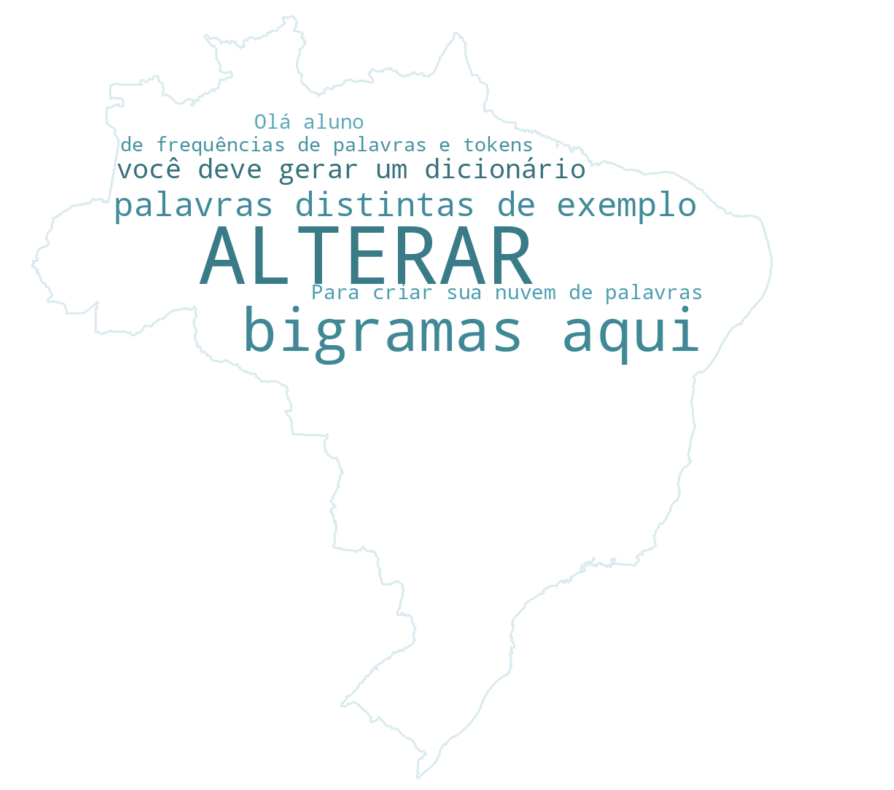

(<wordcloud.wordcloud.WordCloud at 0x784fdddbed40>, 7)

In [ ]:
# Exemplo com dicionário de tokens unigramas e multigramas com frequências
words_dict = {'Olá aluno':1,
              'ALTERAR':4,
              'bigramas aqui':2,
              'palavras distintas de exemplo':2,
              'Para criar sua nuvem de palavras':1,
              'você deve gerar um dicionário':2,
              'de frequências de palavras e tokens':1}
gerar_nuvem_palavras(dicionario_tokens_e_frequencia=words_dict,
                     arquivo_mascara="mapa_brasil_mask.png")

{'de palavras': 2, 'exemplo gerar': 1, 'gerar uma': 1, 'uma nuvem': 1, 'nuvem de': 1, 'palavras usando': 1, 'usando texto': 1, 'texto completo': 1, 'completo você': 1, 'você deve': 1, 'deve primeiro': 1, 'primeiro separar': 1, 'separar ele': 1, 'ele um': 1, 'um um': 1, 'um ou': 1, 'ou mais': 1, 'mais tokens': 1, 'tokens para': 1, 'para só': 1, 'só depois': 1, 'depois vetorizar': 1, 'vetorizar ao': 1, 'ao vetorizar': 1, 'vetorizar você': 1, 'você terá': 1, 'bag of': 1, 'of words': 1, 'words que': 1, 'que te': 1, 'te permitirá': 1, 'permitirá contar': 1, 'contar quantas': 1, 'quantas vezes': 1, 'vezes cada': 1, 'cada palavra': 1, 'palavra ou': 1, 'ou grupo': 1, 'grupo de': 1, 'palavras aparecem': 1, 'aparecem no': 1, 'no texto': 1, 'texto por': 1, 'por fim': 1, 'fim basta': 1, 'basta criar': 1, 'criar um': 1, 'um dicionário': 1, 'dicionário contendo': 1, 'chave como': 1, 'seu token': 1, 'valor como': 1, 'frequência de': 1, 'de aparição': 1, 'aparição deste': 1, 'deste tokem': 1}
   * Um 

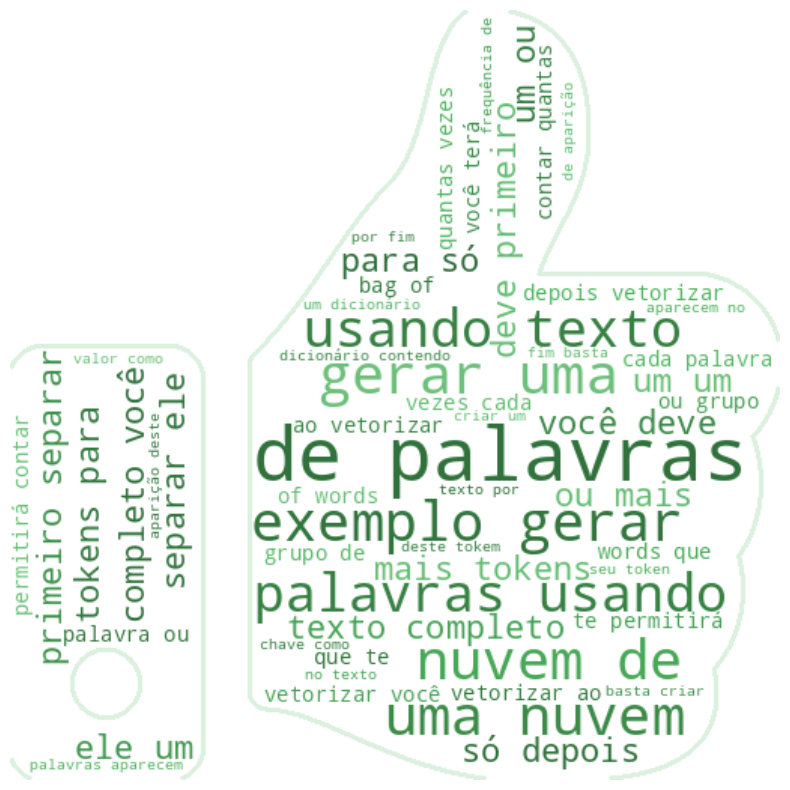

(<wordcloud.wordcloud.WordCloud at 0x784fdddbef20>, 56)

In [ ]:
# Exemplo com uma frase completa
texto = """Exemplo: Gerar uma nuvem de palavras usando texto completo você deve
           primeiro separar ele um um ou mais tokens, para só depois vetorizar.
           Ao vetorizar você terá a bag of words, que te permitirá contar
           quantas vezes cada palavra ou grupo de palavras aparecem no texto.
           Por fim, basta criar um dicionário contendo a chave como o seu token
           e o valor como a frequência de aparição deste tokem."""
# Vetorização e contagem de frequência simples de bigramas:
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform([a+' '+b for a,b in (ngrams(texto.split(),2))])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)
print(words_dict)

gerar_nuvem_palavras(dicionario_tokens_e_frequencia=words_dict,
                      arquivo_mascara='thumbs_up_mask.png')